In [1]:
import os
root_dir = '/home/tim/Dropbox/experimental/' # your path here where to parent directory where repos are
os.chdir(root_dir)
from map_data.map_methods import *
from supervised_learning.supervised_methods import *
from utils.global_methods import *

cpu count: 20
gpu count: 3
cuda avail: True


# init

In [2]:
# the numpy arrays need to match the same floating type used by pytorch here
th.set_default_dtype(th.float32)

# remove some annoying tensorflow logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# set directory to write all results to
run_dir = f'{root_dir}models/monocular_depth/DGNLNet/AirSimNH_v1/'
os.makedirs(run_dir, exist_ok=True)

# set random seeds for replicability
random_seed = 42
set_random_seed(random_seed)

# WARNING --- set file io -- will write model and evalutions to below paths (WILL OVERWRITE SAVED DATA, change if not desirable)
save_model_to = f'{run_dir}model.pth'
save_evals_to = f'{run_dir}evaluations.json'

# harware params -- these are set to run on our lab server Ace, a.k.a. iasl-mlserver2019
device = 'cuda:0'
pytorch_threads = 8 # scale this down with more active processes running at same time
num_workers = 2 # scale this down with RAM constraints
batch_size = 128 # scale this down with VRAM constraints
pin_memory = False # toggle on if training data is small enough to fit in VRAM

# prepare training and validation data

In [3]:
# read data
sample_size = 10_000 # number of data instances to fetch (None to use all available)
data = get_data(
    map_name = 'AirSimNH', # this is the neighorhood map with houses and cars and roads and stuff -- airsim_map can equal 'Blocks' or 'AirSimNH'
    sensor_names = [ # name of sensors to fetch data, see README for available sensors -- names such as 'SceneV1' and 'SegmentationV1'
        'SceneV1',  # SceneV1 is monocular forward facing RGB at 144x256 resolution
        'DepthV1',  # DepthV1 is forward facing 2d depth map at 144x256 resolution
    ],
    region = 'train', # training is done on the top half of the map -- region can equal 'train' 'test' or 'all'
    sample_size = sample_size, # number of data instances to fetch (None to use all available)
)
X = data['observations']['SceneV1'] # RGB
Y = data['observations']['DepthV1'] # to depth
coordinates = data['coordinates'] # list of x, y, z, yaw coordinates at each index corresponding to data

# split into train and validation sets
percent_train, percent_val = 0.8, 0.2
N = len(coordinates)
n_train, n_val = int(percent_train*N), int(percent_val*N)
X_train = X[:n_train]
Y_train = Y[:n_train]
X_val = X[n_train:]
Y_val = Y[n_train:]

# extract parameters from input/ouput data
n_instances = X_train.shape[0]
n_channels = X_train.shape[1] # this is used in code below to make CNN model
n_dim1 = X_train.shape[2]
n_dim2 = X_train.shape[3]

print('Train shape:', X_train.shape, Y_train.shape)
print('Val shape:', X_val.shape, Y_val.shape)

Train shape: (8000, 3, 144, 256) (8000, 1, 144, 256)
Val shape: (2000, 3, 144, 256) (2000, 1, 144, 256)


# process params

In [4]:
X_mean = 94.11807077041952 #np.mean(X_train)
X_std = 80.77841523336176 #np.std(X_train)
Y_min = 0
Y_max = 255

def x_preproc_func(x, _mean, _std):
    return (x.astype(np.float32)-_mean)/_std
def y_preproc_func(y, _min, _max):
    return (y.astype(np.float32)-_min)/(_max-_min)
x_preproc_params={'_mean':X_mean, '_std':X_std}
y_preproc_params={'_min':Y_min, '_max':Y_max}
def unprocess_func(p, _min, _max):
    p = (p*(_max-_min)+_min)#.astype(np.uint8)
    p[p<=1] = 1
    return p
unprocess_params={'_min':Y_min, '_max':Y_max}

# set model architecture

In [5]:
# DGNLNet https://ieeexplore.ieee.org/abstract/document/9318521
# make a scalable CNN following Zixia's depth network inspired from above
scale = 1 # scales number of channels in each layer
model_func = create_cnn # this is my custom method for creating a CNN (of couse you do not have to use it)
model_params = {
    'block_layers':[
            [
                [nn.Conv2d, {'in_channels':n_channels, 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(64*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(128*scale), 'out_channels':int(256*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':4, 'padding':4}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.Conv2d, {'in_channels':int(256*scale), 'out_channels':int(256*scale), 'kernel_size':3, 'dilation':2, 'padding':2}],
                [nn.BatchNorm2d, {'num_features':int(256*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(256*scale), 'out_channels':int(128*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(128*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(128*scale), 'out_channels':int(64*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(64*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(64*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
            ],
            [
                [nn.ConvTranspose2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':4, 'stride':2, 'padding':1}],
                [nn.BatchNorm2d, {'num_features':int(32*scale)}],
                [nn.SELU],
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(32*scale), 'kernel_size':3, 'padding':1}],
                [nn.SELU],
                [nn.Conv2d, {'in_channels':int(32*scale), 'out_channels':int(1), 'kernel_size':1, 'stride':1, 'padding':0}],
                [nn.Sigmoid],
            ],
       ]
}
model = model_func(**model_params).to(device)
print(model)
del model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (1): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SELU()
  )
  (4): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=T

# train model

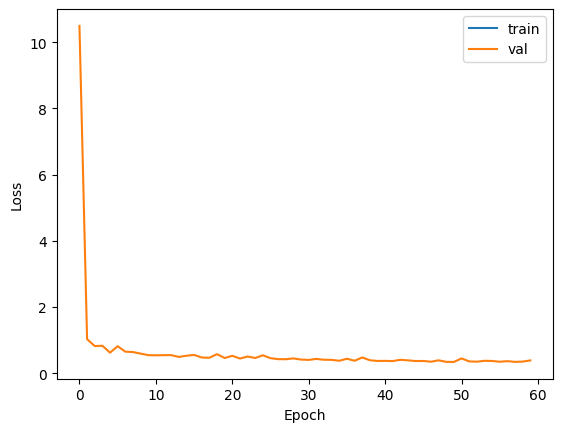

In [6]:
# with the full dataset this practically converges in 1 epoch
# however I have set to do early stopping which takes about 30 minutes to train
model, train_errors, val_errors, train_times = one_shot(model_func, model_params, run_dir, X_train, Y_train, X_val, Y_val,
             optimizier_func=th.optim.Adam, optimizer_params={}, error_func=mean_absolute_percent_error_tensor, minimize_error=True,
             criterion=nn.L1Loss(), patience=10, max_epochs=100, 
             augmentors=None, sample_size=None, device=device, batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=pin_memory,
             checkpoint_freq=0, random_seed=random_seed, mem_optim=True, show_curve=True, show_curve_freq=1,
             x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, y_preproc_func=y_preproc_func, y_preproc_params=y_preproc_params,
            )
th.save(model, save_model_to)

# eval model

{'r2': 0.8561447858810425, 'mape': 0.38597455620765686, 'predict_time': 8.108627796173096, 'train_time': 1048.6821446418762, 'n_epochs': 59}


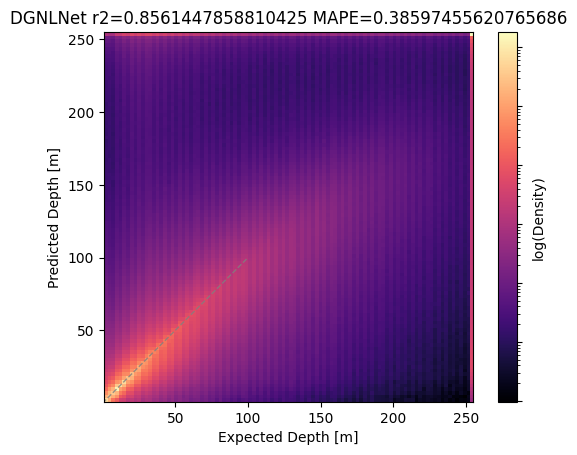

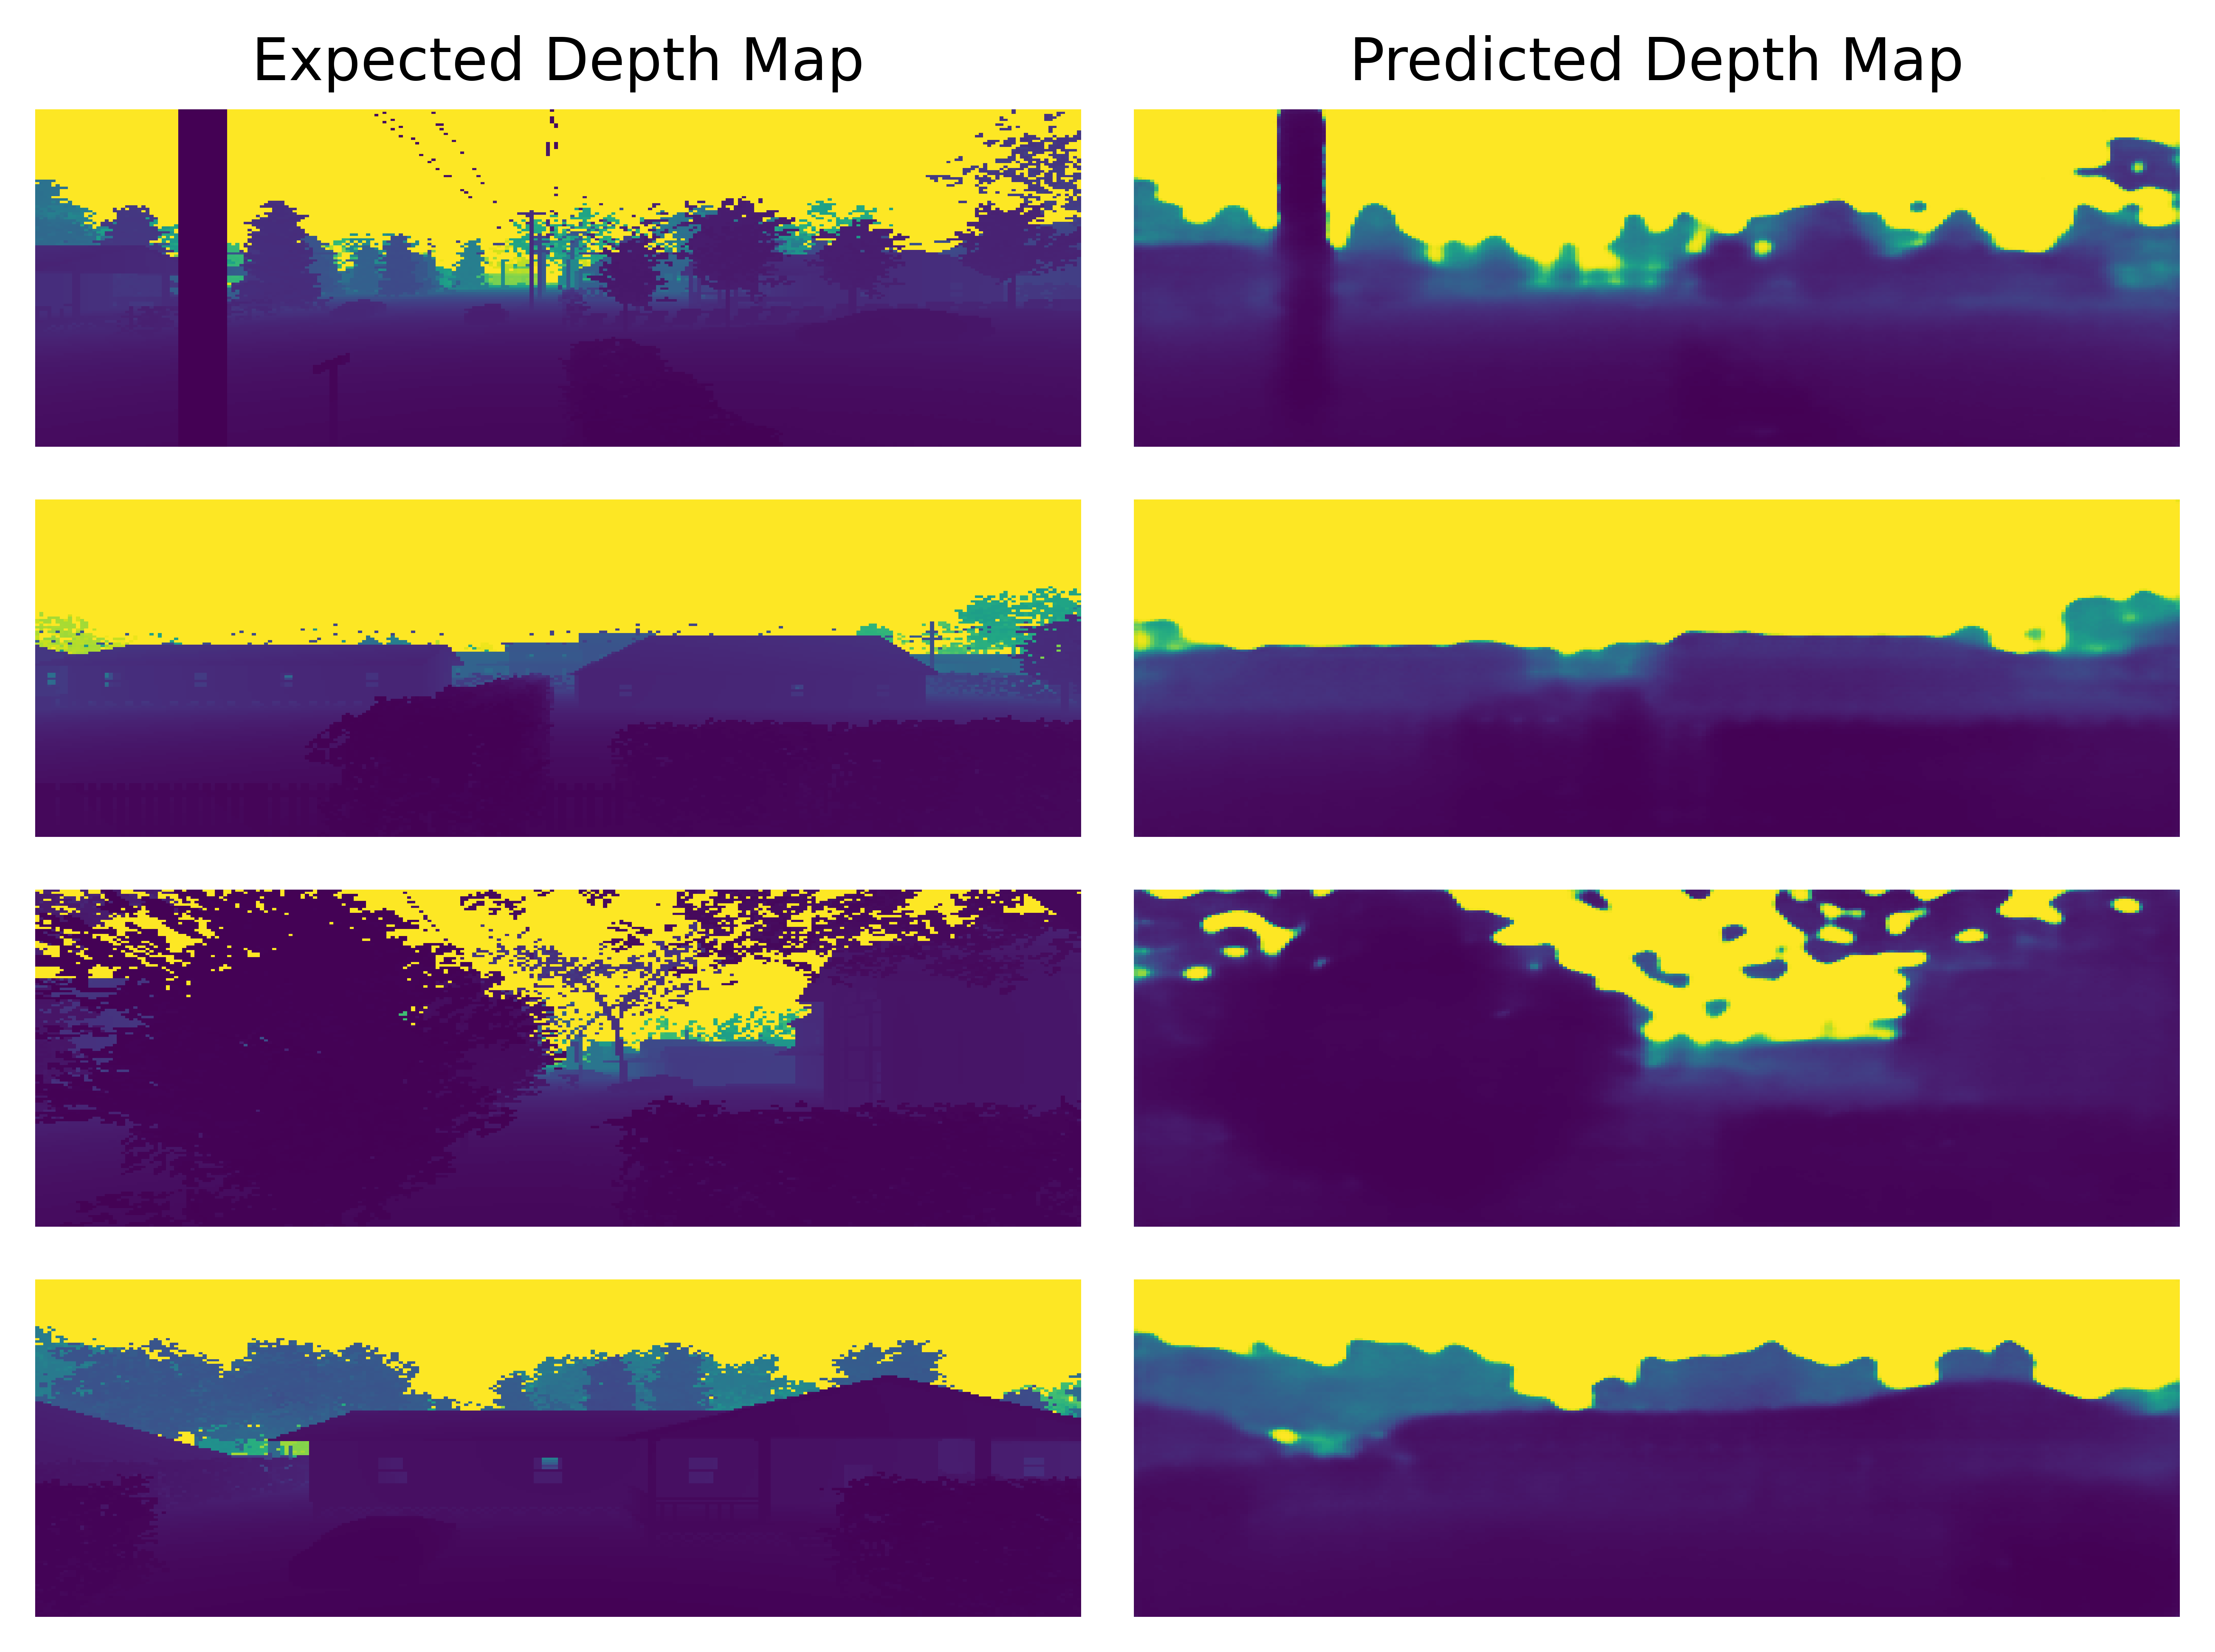

In [7]:
# clear up some RAM
#del X_train, Y_train

#model = th.load(save_model_to)

# test data takes a little under X gb of RAM, and a little under 2 minutes to run
sample_size_test = 10_000 # number of data instances to fetch (None to use all available)
data = get_data(
    map_name = 'AirSimNH', # this is the neighorhood map with houses and cars and roads and stuff -- airsim_map can equal 'Blocks' or 'AirSimNH'
    sensor_names = [ # name of sensors to fetch data, see README for available sensors -- names such as 'SceneV1' and 'SegmentationV1'
        'SceneV1',  # SceneV1 is monocular forward facing RGB at 144x256 resolution
        'DepthV1',  # DepthV1 is forward facing 2d depth map at 144x256 resolution
    ],
    region = 'test', # training is done on the top half of the map -- region can equal 'train' 'test' or 'all'
    sample_size = sample_size_test, # number of data instances to fetch (None to use all available)
)
X_test = data['observations']['SceneV1'] # RGB
Y_test = data['observations']['DepthV1'] # to depth
coordinates_test = data['coordinates']
    
P_test, predict_time = predict_model(model, device, X_test, Y_test.shape, x_preproc_func=x_preproc_func, x_preproc_params=x_preproc_params, 
                       batch_size=batch_size, pytorch_threads=pytorch_threads, num_workers=num_workers, pin_memory=False,)
P_test = unprocess_func(P_test, **unprocess_params)
r2 = r2_score(Y_test, P_test)
mape = mean_absolute_percent_error_numpy(Y_test, P_test)
evaluations = {
    'r2':r2,
    'mape':mape,
    'predict_time':predict_time,
    'train_time':float(np.sum(train_times)),
    'n_epochs':len(train_times)-1,
}
print(evaluations)
evaluations['train_errors'] = train_errors
evaluations['val_errors'] = val_errors
evaluations['train_times'] = train_times
write_json(evaluations, save_evals_to)

hist, x_edges, y_edges = np.histogram2d(Y_test.flatten(), P_test.flatten(), bins=100, density=True)

fig, ax = plt.subplots()
ax.plot([x for x in range(0, hist.shape[0])], [y for y in range(0, hist.shape[1])], 
         color='grey', linestyle='--', linewidth=1, alpha=0.8)
im = ax.imshow(hist.T, origin='lower', norm=mcolors.LogNorm(),#vmin=0, vmax=1, clip=True),
               extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]], cmap='magma', aspect='equal')
ax.set_title(f'DGNLNet r2={r2} MAPE={mape}')
ax.set_xlabel('Expected Depth [m]')
ax.set_ylabel('Predicted Depth [m]')
cbar = plt.colorbar(im, label='log(Density)')
cbar.ax.set_xticklabels([])
cbar.ax.set_yticklabels([])
plt.show()

nsamples = 4
fig, axs = plt.subplots(nrows=nsamples, ncols=2, dpi=1000)#, figsize=(4*nsamples, 16))
axs[0,0].set_title('Expected Depth Map')
axs[0,1].set_title('Predicted Depth Map')
for i in range(nsamples):
    idx = random.randint(0, len(Y_test))
    axs[i, 0].imshow(Y_test[idx][0])
    axs[i, 1].imshow(P_test[idx][0])
    axs[i, 0].axis('off')
    axs[i, 1].axis('off')
    axs[i, 0].set_aspect('auto')
    axs[i, 1].set_aspect('auto')
plt.tight_layout()
plt.show()

# clear up some RAM
#del X_test, Y_test, P_test

In [8]:
mean_absolute_percent_error_numpy(Y_test, P_test)

0.38597455620765686

In [9]:
mapes = []
for i in range(len(P_test)):
    mape = mean_absolute_percent_error_numpy(Y_test[i], P_test[i])
    mape = min(mape, 1)
    mapes.append(mape)

(array([  8.,   9.,  31.,  55., 102., 140., 140., 203., 271., 273., 328.,
        330., 361., 377., 354., 347., 339., 321., 320., 315., 292., 292.,
        268., 275., 246., 226., 202., 198., 183., 199., 158., 136., 113.,
        136., 122., 112.,  95.,  99.,  80.,  88.,  59.,  99.,  60.,  79.,
         54.,  46.,  47.,  46.,  51.,  52.,  29.,  51.,  30.,  40.,  27.,
         29.,  37.,  31.,  13.,  27.,  36.,  23.,  22.,  18.,  23.,  17.,
         17.,  24.,  19.,  15.,  12.,  12.,  11.,  19.,  14.,  13.,  17.,
         14.,  19.,  14.,  11.,  13.,   8.,   8.,  14.,   8.,   9.,   8.,
          8.,   8.,   2.,   9.,  10.,   6.,   8.,   4.,   8.,   8.,   9.,
        431.]),
 array([0.07087318, 0.08016445, 0.08945571, 0.09874698, 0.10803825,
        0.11732952, 0.12662079, 0.13591206, 0.14520332, 0.15449459,
        0.16378586, 0.17307713, 0.1823684 , 0.19165967, 0.20095093,
        0.2102422 , 0.21953347, 0.22882474, 0.23811601, 0.24740727,
        0.25669854, 0.26598981, 0.27528108, 0.

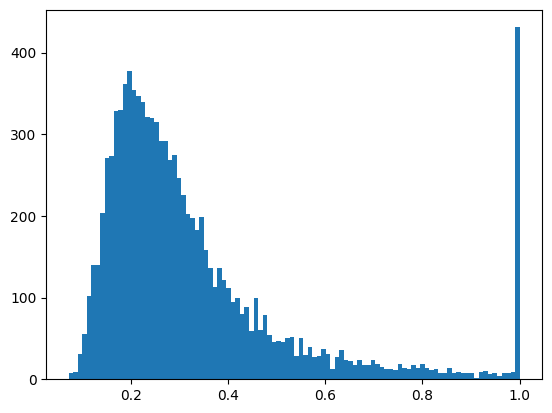

In [10]:
plt.hist(mapes, bins=100)